# Code Understanding with Local LLMs

This notebook provides insights into building a Code Understanding App using Local LLMs and a RAG architecture. \
*Please notice that the notebook is still being edited.*

**Use Cases**

In the realm of software development, grappling with ill documented or poorly written code is a common challenge that consumes valuable time and resources. 

Despite source code analysis being one of the most popular LLM applications, traditional web-based interfaces come with their own set of limitations.
One primary constraint is the restricted context provided by these interfaces, making it challenging to grasp the full scope and intricacies of the code under examination. Moreover, concerns regarding data privacy and security loom large, as sensitive codebases may contain proprietary or confidential information that cannot be safely processed on remote servers.

By leveraging the power of Retrieval-Augmented Generation (RAG) combined with a model running locally, these concerns can be at least alleviated.
Indeed, this approach could help developers navigating through complex codebases with greater efficiency and confidence, while preserving data privacy and security. 


**Tech Stack**

- LangChain (Application Framework)
- HuggingFace SentenceTransformers (Text Embedding)
- FAISS (Vector Store)
- Ollama (Local LLMs Platform)
- Gemma:7b (LLM)

**Sources** 

Most of the content of this notebook follow along the documentation and example pages of [LangChain documentation](https://python.langchain.com/docs/get_started/introduction). We tried gathering and integrating further details for a novice of the LLM landscape. Please refer to the linked original sources whenever possible.

## Notes on the [RAG Architecture ](https://python.langchain.com/docs/use_cases/question_answering)

RAG models combine the strengths of both retrieval-based and generation-based approaches. By retrieving relevant context from a large corpus of documents before generating a response, RAG models can produce more relevant and updated outputs compared to generation-only models. Indeed, recall that all LLMs have a cutoff date in their training data. 

A typical RAG application consists of two main components:

**Indexing**

Indexing involves a pipeline for ingesting data from a source and indexing it. This process typically occurs offline.

1. **Load**: The first step is to load the data from the textual files.
2. **Split**: Text splitters divide large documents into smaller chunks, which is beneficial for both indexing data and passing it to a model. This is because large chunks are harder to search over and may not fit within a model's finite context window.
3. **Store**: It's necessary to have a place to store and index the splits so that they can be later searched over. This is often accomplished using a Vector Store and an Embedding model.



**Retrieval and Generation**

This phase involves the actual use of the RAG chain, which takes the user query at runtime and retrieves relevant data from the index, then passes it to the model.

1. **Retrieve**: Relevant splits are retrieved from storage based on user input, using a Retriever.
2. **Generate**: An LLM produces an answer using a prompt that includes both the question and the retrieved data.


## Indexing Steps

#### Documents loading and splitting

- To load source code contents, we use `DocumentLoaders`, which return a list of `Documents` with content and metadata
- `glob="**/*"` includes the folder in path and all subfolders
- `LanguageParser` class of LangChain is useful because it effectively organizes the source code, maintains logical groupings of functions and classes, separates code elements for clarity, and preserves important metadata for context and traceability.
- The `parser_threshold` is used to set the minimum number of lines required to activate the splitting based on syntax when parsing code using the respective programming language syntax. This parameter allows for more precise segmentation of code by loading each top-level function and class into separate documents.

In [1]:
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers import LanguageParser
from langchain_text_splitters import Language, RecursiveCharacterTextSplitter

folder_name = "/Users/antoniocusano/Coding/WebScraper"
language = Language.PYTHON

In [2]:
# Load
loader = GenericLoader.from_filesystem(
    path=folder_name,
    glob="**/*",
    suffixes=[".py"],
    parser=LanguageParser(language=language, parser_threshold=10),
)
documents = loader.load()

- Documents are split into chunks, since the documents may not fit in the context window of many models.
- `RecursiveCharacterTextSplitter` splits text by recursively look at a list of separator characters 
- For Python language, first it tries to split along class definitions (`class`, `def`, ...) then split by the normal type of line (`\n`, `" "`, ...)
- The characters of overlap help to preserve context.
- Notice that there are at least two limits that must be taken into account: the context length of the LLM (at inference time) and the max sequence length of the embedding model (at training time)

In [3]:
# Split
code_splitter = RecursiveCharacterTextSplitter.from_language(
    language=language, chunk_size=750, chunk_overlap=75
)
doc_chunks = code_splitter.split_documents(documents)

print(f"{len(documents)} documente loaded ({len(doc_chunks)} chunks after split).")

52 documente loaded (100 chunks after split).


In [4]:
print("Sample document chunks: \n")
for ii in range(5):
    print(doc_chunks[ii].page_content[:50])

Sample document chunks: 

import streamlit as st

st.set_page_config(
    pa
### Car Evaluator
    The data collected were used
def filter_usedcars_data(
    df, max_price=1e6, m
def load_data(nrows: int):
    columns = [
       
data["date"] = pd.to_datetime(data["date"])
    re


In [5]:
# Expected max number of tokens per document chunk 
# 5 characters per word, 0.75 word per token -> 4 characters per token
int(max([len(sent.page_content.split())*4/3 for sent in doc_chunks]))

110

####  Index generation/loading

- We need to index our text chunks so that we can search over them at runtime.
- We can embed the contents of each document split and insert these embeddings into a vector database (or vector store). 
- To search over our splits, we take a text search query, embed it, and perform a similarity search (e.g. cosine similarity) to identify the stored splits with the most similar embeddings to our query embedding.
- As pointed out in [HuggingFace Documentation](https://huggingface.co/learn/cookbook/advanced_rag), it is important to check the embedding sequence length limit.
- In this case most of the splits are shorter than 256 tokens, just few are longer.
- Longer sequences may be truncated without a warning!

In [6]:
embedding_model_name = 'sentence-transformers/all-MiniLM-L6-v2'

Model's maximum sequence length: 256
Doc chunks maximum sequence length: 378
Doc chunks median sequence length: 175


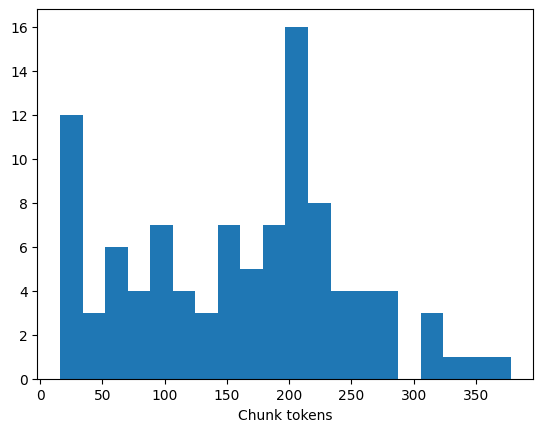

In [7]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt


print(f"Model's maximum sequence length: {SentenceTransformer(embedding_model_name).get_max_seq_length()}")

tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in doc_chunks]

print(f"Doc chunks maximum sequence length: {np.max(lengths)}")
print(f"Doc chunks median sequence length: {int(np.median(lengths))}")

plt.hist(lengths, bins=20)
plt.xlabel('Chunk tokens')
plt.show()


- Facebook AI Similarity Search ([FAISS](https://faiss.ai/)) is a library for efficient similarity search and clustering of dense vectors
- The default similarity measure is euclidean distance in FAISS

In [10]:
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [11]:
# embeddings generation
embeddings= HuggingFaceEmbeddings(model_name=embedding_model_name)
vector_db = FAISS.from_documents(doc_chunks,embeddings)
vector_db.save_local("./embeddings")

In [ ]:
# embeddings loading
embeddings= HuggingFaceEmbeddings(model_name=embedding_model_name)
vector_db = FAISS.load_local("embeddings", embeddings, allow_dangerous_deserialization=True)

## Retrieval and Generation

####  Sample retrieval

- LangChain defines a `Retriever` interface which wraps an index that can return relevant documents given a string query.
- `VectorStoreRetriever` uses the similarity search capabilities of a vector store to facilitate retrieval. Any `VectorStore` can easily be turned into a Retriever with `VectorStore.as_retriever()`
- You can specify the number $k$ of most relevant documents to retrieve
- By default, the vector store retriever uses similarity search, but you can specify maximum marginal relevance search as the search type if supported.
- The `MaxMarginalRelevanceExampleSelector` selects examples based on a combination of which examples are most similar to the inputs, while also optimizing for diversity

In [12]:
retriever = vector_db.as_retriever(search_type="mmr", search_kwargs={"k": 10},)

In [20]:
query = "What do the scraper do?"
docs_retrieved = retriever.invoke(query)
print(docs_retrieved[0].page_content)

def get_scraper_path():
    return os.path.join(".", "usedcars_scraper.py")


### Setup of a local large language model

- In LangChain, there are two main components of language models: Large Language Models (LLMs) and Chat Models, each serving distinct purposes
- LLMs are more general-purpose, they take a string as input and return a string as output. 
- Chat Models are specialized for conversational tasks, they take a list of messages as input and return a chat message
- Notice that LangChain does not serve its own LLMs, but rather provides a standard interface for interacting with many different LLMs
- LangChain has integrations with many open-source LLMs that can be run locally.

- [Ollama](https://ollama.com/) is a free tool to run open-source large language models locally
- Examples of model (families) that can be run in ollama include Gemma, Llama 2, Mistral...
- To interact with models via Ollama, users can run commands like ```ollama run <name-of-model>``` to chat directly with a model from the command line
- They can also send prompts to the models via a [REST API](https://github.com/ollama/ollama/blob/main/docs/api.md):  ```curl http://localhost:11434/api/generate -d '{"model": "gemma:7b","prompt":"Tell me a joke"}' ```
- Here we use the Langchain Ollama integration 

In [21]:
from langchain_community.llms import Ollama

llm = Ollama(model="gemma:7b")
llm.invoke("Tell me a joke about programming")

'Why did the programmer cross the road?\n\nTo get to the other bug-free side.'

### Setup of a Prompt template

- A prompt template is a piece of text to complete with an input to and produces a prompt for a language model.
- One can use LangChain Prompt Hub to store and fetch prompts or use the class `PromptTemplate`
- `rlm/rag-prompt` is a prompt template for retrieval-augmented-generation. It is useful for chat, QA, or other applications that rely on passing context to an LLM.

**rlm/rag-prompt** 

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. \
\
Question: {question} \
Context: {context} \
Answer:

In [22]:
from langchain import hub

# RAG prompt
prompt = hub.pull("rlm/rag-prompt")

# Sample prompt
prompt.invoke({"context": "filler context", "question": "filler question"})

ChatPromptValue(messages=[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:")])

### Setup of a Q&A with retrieval chain

- In LangChain, a "chain" is a fundamental component that forms the backbone of the platform's functionality. They are essentially sequences of components executed in a specific order to a task.
- There are two types of off-the-shelf chains that LangChain supports:
    - Chains that are built with LangChain Expression Language (LCEL), e.g. ```chain = prompt | model | output_parser```
    - Chains constructed by subclassing from a legacy Chain class, e.g. ```qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever, chain_type_kwargs={"prompt": prompt) ```
- Here we put together in a chain all our ingredients: the retriever, the llm and the prompt template
- We add an output parser to transform the output of the LLM into a more readable format

In [23]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [24]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

###  Generation of Q&A

- The pipeline is complete and the question can be asked
- The answer is acceptable, altough it takes long to aswer on a laptop without a dedicated GPU (2020 MacBook Pro, 2 GHz Intel Core i5 CPU, 16 GB RAM) 
- However, if privacy is not a concern, one can just replace the `llm` component of the pipeline with a larger model to be called via API (e.g. GPT-4)

In [25]:
question = "What attributes of the cars are collected?"
rag_chain.invoke(question)

'Sure, here is the answer to the question:\n\nThe attributes of the cars collected in the data include model, age, power, fuel type, gear type, engine size, wheel drive, body type, offer date.'

###  Further investigation

This was just a simple personal experiment. The areas of improvement for a more commited project would include:

- Chunking of the codebase -> a proper choice of the chunking strategy and size can boost the performance at no cost
- Reranking -> adding to the pipeline a component that reranks the results (leveraging a more powerful retrieval model) before keeping only the top k.
- Larger LLM -> replace the relatively small local model with a larger one accessible via API (e.g. 🤗 Hosted Inference API)
- An evalutaion pipeline should be implemented to quantitatively compare different pipeline architectures